<a href="https://www.kaggle.com/code/kulbaka/classification-naivebayes-randomforest-bert?scriptVersionId=150746676" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

# Visualizaton
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_palette(sns.color_palette("viridis"))

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# NLP
import spacy
nlp = spacy.load("en_core_web_sm") 

# ML - for BERT
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# **Load Data**

In [2]:
df = pd.read_csv('/kaggle/input/emotion-dataset/Emotion_classify_Data.csv')
df.columns = [c.lower() for c in df.columns]

# Print dataset statistics
print('\n\n___________Df Info:\n')
print(df.info())
print('\n\n___________Descriptive statistics:\n',df.describe(),'\n\n')
print('\n\n___________Number of duplicated rows:  ', df.duplicated().sum(),'\n\n')

# Look at the example of data
df.head()



___________Df Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  5937 non-null   object
 1   emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB
None


___________Descriptive statistics:
                                                  comment emotion
count                                               5937    5937
unique                                              5934       3
top     i feel like a tortured artist when i talk to her   anger
freq                                                   2    2000 




___________Number of duplicated rows:   0 




,comment,emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


# **Check Target Distribution**

Checking the target distribution in text classification is crucial for several reasons:

1. **Model Performance Evaluation:**
   - Understanding the distribution of target classes helps in interpreting the accuracy of a model. If the classes are imbalanced, accuracy alone may not be a reliable metric. For instance, in imbalanced datasets, a model may achieve high accuracy by simply predicting the majority class most of the time. In such cases, other metrics like precision, recall, F1 score, or area under the receiver operating characteristic curve (AUC-ROC) may provide a more comprehensive evaluation.


2. **Bias and Fairness Assessment:**
   - Examining the target distribution is essential for identifying potential biases in the dataset. Biases can lead to models that favor certain classes over others, and this may result in unfair or discriminatory outcomes. It's important to ensure that the training dataset represents the real-world distribution of classes to mitigate bias in the model.


3. **Impact on Training Dynamics:**
   - Imbalanced target distributions can affect the training dynamics of machine learning models. Models trained on imbalanced datasets might converge faster on the majority class, potentially ignoring minority classes. This can be addressed by using techniques such as class weighting or resampling strategies during training.


4. **Choosing Appropriate Evaluation Metrics:**
   - The choice of evaluation metrics depends on the nature of the target distribution. In addition to accuracy, metrics like precision, recall, and F1 score are sensitive to the distribution of positive and negative samples. For instance, in fraud detection or rare-event classification, where the positive class is rare, precision-recall metrics might be more informative than accuracy.


5. **Handling Class Imbalance:**
   - If there is a significant class imbalance, it may be necessary to employ strategies to address it, such as oversampling the minority class, undersampling the majority class, or using more advanced techniques like Synthetic Minority Over-sampling Technique (SMOTE) or cost-sensitive learning. The decision to address class imbalance depends on the goals of the classification problem.


6. **Real-world Generalization:**
   - Ensuring that the target distribution in the training set reflects the distribution in the real world is crucial for the model to generalize well to unseen data. If the training distribution is significantly different from the distribution in the application domain, the model's performance might degrade when applied to new data.

In summary, checking the target distribution is an integral part of the data exploration and preprocessing phase in text classification. It guides model evaluation, helps identify biases, influences training dynamics, and informs the choice of appropriate metrics and strategies for handling class imbalance.

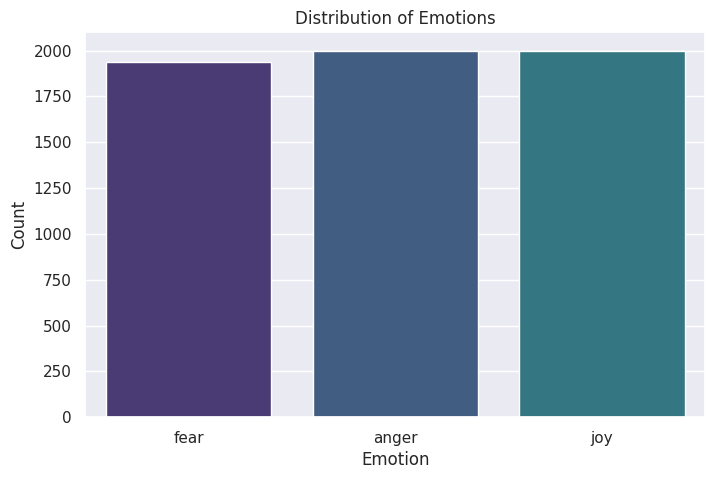

In [3]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='emotion')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# **Naive Bayes Classifier**

Naive Bayes is a probabilistic machine learning algorithm based on Bayes' theorem, which describes the probability of an event based on prior knowledge of conditions that might be related to the event. In the context of text classification, Naive Bayes is commonly used for tasks such as spam detection, sentiment analysis, and topic categorization.


### Bayes' Theorem:

Bayes' theorem is expressed as:

$$ P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)} $$

In the context of text classification:

- $ P(A|B) $ is the probability of a document belonging to class A given its features (words in the document).
- $ P(B|A) $ is the probability of observing the features (words) given that the document belongs to class A.
- $ P(A) $ is the prior probability of a document belonging to class A.
- $ P(B) $ is the probability of observing the features (words).

### "Naive" Assumption:

The "naive" assumption in Naive Bayes is that the features (words in the document) are conditionally independent, given the class label. This means that the presence or absence of a particular word in a document is assumed to be independent of the presence or absence of other words, given the class label.

### Text Classification with Naive Bayes:

Let's consider a binary classification problem with two classes, A and B:

- **Training:**
  - Calculate the prior probabilities $ P(A) $ and $ P(B) $ based on the training data.
  - For each word $ w_i $ in the vocabulary, calculate the conditional probabilities $ P(w_i|A) $ and $ P(w_i|B) $.

- **Testing:**
  - Given a new document with features (words), calculate $ P(A|words) $ and $ P(B|words) $ using Bayes' theorem.
  - Assign the class label with the higher probability.

### Laplace Smoothing:

To handle the issue of zero probabilities when a word in the test document hasn't been seen in the training data, Laplace smoothing (or add-one smoothing) is often applied. This involves adding a small constant to the observed counts of each word.



We want to classify a document sentiment as either 'joy', 'fear' or 'anger' based on the words it contains. 
Naive Bayes would calculate the probabilities of the document belonging to each class given the words and then assign the class with the higher probability.

`While Naive Bayes has its limitations, such as the independence assumption, it is computationally efficient and often performs well in practice, especially for text classification tasks with large datasets.`

In [4]:
# Tokenize and format the data
def preprocess_text(text):
    doc = nlp(text)
    words = []
    for w in doc:
        if w.is_stop or w.is_punct:
            continue
        words.append(w.lemma_)
    return " ".join(words) 
df['comment_preprocessed'] = df['comment'].progress_apply(preprocess_text) 

# Encode target variable
df['emotion_encoded'] = df['emotion'].map({'joy' : 0, 'fear': 1, 'anger': 2})

# Split the data into training and testing sets
X = df['comment_preprocessed']
y = df['emotion_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Vectorize text
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Baseline model
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vectorized, y_train)
y_pred = naive_bayes.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
classification_report_nb_base = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_nb_base)

100%|██████████| 5937/5937 [00:59<00:00, 100.02it/s]


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       400
           1       0.91      0.90      0.91       388
           2       0.90      0.92      0.91       400

    accuracy                           0.90      1188
   macro avg       0.90      0.90      0.90      1188
weighted avg       0.90      0.90      0.90      1188



In [5]:
# Searching for best `alpha` hyperporameter 

naive_bayes = MultinomialNB()
param_grid = {'alpha': np.linspace(0.1, 1.5, 15)}
grid_search = GridSearchCV(naive_bayes, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Naive Bayes classifier with the best alpha
best_naive_bayes = MultinomialNB(alpha=best_alpha)
best_naive_bayes.fit(X_train_vectorized, y_train)

# Predictions on the test set
y_pred = best_naive_bayes.predict(X_test_vectorized)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
classification_report_nb_best = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_nb_best)

Best alpha: 1.5
Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       400
           1       0.91      0.91      0.91       388
           2       0.90      0.93      0.91       400

    accuracy                           0.91      1188
   macro avg       0.91      0.91      0.91      1188
weighted avg       0.91      0.91      0.91      1188



# **Random Forest Classifier**

Random Forest is an ensemble learning method that can be used for text classification, just as it can be applied to various other machine learning tasks. The basic idea behind Random Forest is to build multiple decision trees and combine their predictions to improve the overall performance and generalization of the model.

Here's a step-by-step explanation of how Random Forest works for text classification:

### 1. Ensemble of Decision Trees:

Random Forest creates an ensemble of decision trees. Each decision tree is trained independently on a random subset of the training data and a random subset of features. This randomness helps to ensure diversity among the trees.

### 2. Bagging (Bootstrap Aggregating):

The random subsets are created through a process called bootstrapping, where random samples are drawn with replacement from the original training data. This results in multiple subsets, and each decision tree is trained on one of these subsets.

### 3. Feature Randomization:

At each node of a decision tree, instead of considering all features, only a random subset of features is considered for splitting. This further adds diversity to the trees and helps prevent overfitting.

### 4. Decision Tree Training:

Each decision tree is trained independently using the chosen subset of data and features. The splitting of nodes is based on the feature that provides the best separation according to a specified criterion (e.g., Gini impurity for classification tasks).

### 5. Prediction:

For a new input (e.g., a new text document), each decision tree in the forest makes a prediction. In classification tasks, the class that receives the majority of votes from all trees is the final predicted class.

### Advantages of Random Forest for Text Classification:

1. **Robust to Overfitting:** The ensemble nature of Random Forest helps to reduce overfitting, making it more robust on unseen data.

2. **Handles High-Dimensional Data:** Random Forest can handle high-dimensional data, such as the bag-of-words representation of text, effectively.

3. **Feature Importance:** Random Forest provides a measure of feature importance, which can be helpful in understanding which words or features contribute most to the classification.

In [6]:
y = df['emotion']

# Convert text data into a bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['comment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train Random Forest classifier
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
classification_report_rf_base = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_rf_base)

Accuracy: 0.93
              precision    recall  f1-score   support

       anger       0.93      0.92      0.92       497
        fear       0.94      0.91      0.93       505
         joy       0.91      0.96      0.93       483

    accuracy                           0.93      1485
   macro avg       0.93      0.93      0.93      1485
weighted avg       0.93      0.93      0.93      1485



In [7]:
# Create a Random Forest classifier
random_forest = RandomForestClassifier()

### UNCOMMENT to prerform hyperparameter search 

# Define the hyperparameter grid to search
# param_grid = {
#    'n_estimators': [50, 100, 150],
#    'max_depth': [None, 10, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
# }

# Grid search with cross-validation
# grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# Best hyperparameters
# best_params = grid_search.best_params_
# print(f"Best Hyperparameters: {best_params}")

best_params = {'min_samples_leaf': 2, 
               'max_depth': None, 
               'min_samples_split': 2, 
               'n_estimators': 150}

# Train the Random Forest classifier with the best hyperparameters
best_random_forest = RandomForestClassifier(**best_params)
best_random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred = best_random_forest.predict(X_test)

# Evaluate on the test set
accuracy = accuracy_score(y_test, y_pred)
classification_report_rf_best = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report_rf_best)

Accuracy: 0.93
              precision    recall  f1-score   support

       anger       0.94      0.93      0.94       497
        fear       0.95      0.91      0.93       505
         joy       0.91      0.95      0.93       483

    accuracy                           0.93      1485
   macro avg       0.93      0.93      0.93      1485
weighted avg       0.93      0.93      0.93      1485



# **BERT**

BERT (Bidirectional Encoder Representations from Transformers) is a powerful pre-trained natural language processing (NLP) model developed by Google. It has revolutionized the field of NLP by achieving state-of-the-art results in various tasks, including text classification. BERT is part of the Transformer architecture, which was introduced in the paper "Attention is All You Need" by Vaswani et al.


Here's an explanation of BERT for text classification:

### 1. **Pre-training:**

BERT is pre-trained on large amounts of text data in an unsupervised manner. During pre-training, BERT learns to predict missing words in a sentence (masked language model) and understand the relationships between words bidirectionally. It captures contextual information by considering both the left and right context of each word in a sentence.

### 2. **Transformer Architecture:**

BERT utilizes the Transformer architecture, which includes self-attention mechanisms. Self-attention allows the model to weigh the importance of different words in a sentence based on their context, resulting in a contextualized representation for each word.

### 3. **Bidirectional Context:**

One of the key features of BERT is its bidirectional context understanding. Unlike traditional models that process text in a left-to-right or right-to-left manner, BERT considers both directions simultaneously. This bidirectional processing enables BERT to capture richer contextual information.

### 4. **Tokenization:**

BERT tokenizes input text into subwords, words, or WordPieces, which allows it to handle a wide vocabulary and capture the meaning of rare words or subwords.

### 5. **Text Classification using BERT:**

For text classification tasks, BERT can be fine-tuned on a specific dataset with labeled examples. The pre-trained BERT model serves as a feature extractor, and additional layers are added for task-specific classification. The entire model is then fine-tuned on the classification task using labeled data.


We will use Hugging Face `transformers` library to acess pre-trained BERT models. 
The model is fine-tuned on a binary classification task using the labeled training data, and its performance is evaluated on the test set.

### Check if CUDA is available

In [8]:
# Check for cuda
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print('device_count: ', torch.cuda.device_count())
print('device_name: ', torch.cuda.get_device_name(0))
print('cuda is available: ', torch.cuda.is_available())

# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

0
device_count:  1
device_name:  Tesla P100-PCIE-16GB
cuda is available:  True
Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [9]:
# Split the data into training and testing sets using origianl data
X = df['comment'] 
y = df['emotion']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to category data type
y_train = y_train.astype('category')
y_test = y_test.astype('category')

In [10]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(y_train.cat.categories))

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the loss function
criterion = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Tokenize and format the data
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors='pt')
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, return_tensors='pt')

y_train_encodings = torch.tensor(y_train.cat.codes.values)
y_test_encodings = torch.tensor(y_test.cat.codes.values)

# Create DataLoader for efficient batch processing
train_dataset = TensorDataset(X_train_encodings['input_ids'], X_train_encodings['attention_mask'], y_train_encodings)
test_dataset = TensorDataset(X_test_encodings['input_ids'], X_test_encodings['attention_mask'], y_test_encodings)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Training BERT Model

In [12]:
num_epoch = 1

for epoch in range(num_epoch):
    print('epoch number: ',epoch)
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        output = model(input_ids, attention_mask=attention_mask)
        logits = output.logits
        
        # Convert labels to torch.Long data type
        labels = labels.long()
        
        # CrossEntropy Loss
        loss = criterion(logits, labels)  
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {average_loss:.4f}")

epoch number:  0


100%|██████████| 594/594 [23:34<00:00,  2.38s/it]

Epoch 1, Loss: 0.5516


### BERT Model Evaluation

In [13]:
model.eval()
predictions = []
true_labels = []

for batch in tqdm(test_dataloader):
    input_ids, attention_mask, labels = batch
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
    predicted_labels = torch.argmax(output.logits, dim=1)
    predictions.extend(predicted_labels.tolist())
    true_labels.extend(labels.tolist())

# Decode labels to original classes
predicted_emotions = y_train.cat.categories[predictions]
true_emotions = y_train.cat.categories[true_labels]

# Evaluate model
accuracy = accuracy_score(true_emotions, predicted_emotions)
classification_report_bert = classification_report(true_emotions, predicted_emotions)

print(f'Accuracy: {accuracy:.2f}')
print(classification_report_bert)

100%|██████████| 149/149 [01:12<00:00,  2.05it/s]

Accuracy: 0.94
              precision    recall  f1-score   support

       anger       0.90      0.97      0.94       392
        fear       0.96      0.92      0.94       416
         joy       0.97      0.94      0.95       380

    accuracy                           0.94      1188
   macro avg       0.94      0.94      0.94      1188
weighted avg       0.94      0.94      0.94      1188



In [14]:
#torch.save(model.state_dict(), 'emotion_detection_model.pth')